### Extract field from invoices using GPT-4o

In [ ]:
#Install Dependencies
%pip install python-dotenv
%pip install openai
%pip install PIL


In [3]:
import base64
import datetime
import glob

import openai
import os
import requests
import sys

from dotenv import load_dotenv
from io import BytesIO
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image

#### Get config details

In [9]:
# Load environment variables
load_dotenv('config.env')

# Get the connection strings and other secrets
api_base = os.getenv('AOAI_ENDPOINT')
api_key = os.getenv('AOAI_KEY')
api_version= os.getenv('AOAI_API_VERSION')
img_path = os.getenv('IMAGE_PATH')

# This is the deployed name of your GPT-4o model from the Azure Open AI studio
model = "gpt-4o"

# Print to verify
print(f'Azure OpenAI API Version: {api_version}')
print(f'Image path: {img_path}')


Azure OpenAI API Version: 2024-08-01-preview
Image path: invoice/png/


#### Testing the model

In [10]:
def gpt4o_text(prompt):
    """
    Gpt-4o model
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.7,
    )

    return response

In [11]:
result = gpt4o_text("Who are you?")
print(result.choices[0].message.content)

I am an AI language model created by OpenAI, here to assist you with information and answer your questions to the best of my abilities. How can I help you today?


#### System prompt for invoice processing

In [14]:
# Define System Prompt
prompt = ''' 
You are a helpul assistant who understands various invoice formats.
Given an invoice, which could be a single image or multiple images, your task is to extract specific fields from the invoice images. 
The fields to be extracted are as follows:

    Vendor Name
    Vendor VAT Registration Number
    Invoice or Credit
    Invoice Number
    Credit Reference
    Invoice Date
    Currency
    Net Amount
    Tax Amount
    Freight
    Misc Charges
    Total Amount
    Purchase Order Number

###Guidelines:###
	If an invoice contains multiple Purchase Orders (POs), the Purchase Order field will repeat. This field **MUST BE** kept as an array. 
	Purchase Order field might not be present in all invoices. You **MUST** return an empty array in such cases and **MUST NOT** fabricate values. 
	Purchase Order field usually starts with "PU" and it's 10 characters long including "PU" in the beginning. Please ignore anything after 10 characters or before "PU". eg: If PO number is XX-PU11111111-01, you must return PU11111111.


	The Vendor Name and Vendor VAT Registration Number are associated with the entity issuing the invoice, not with the 'ship to', 'sold to', 'customer', or 'billed to' fields. The Vendor Name is not 'RENISHAW', 'RENISHAW PLC' or anything similar.
	You **MUST** return the Vendor/Supplier VAT Registration Number (VAT ID) as specified in the invoice image.

	The Invoice Date **MUST** always be returned in the 'dd/MM/yyyy' format. If the Invoice date is in a different format, eg: yy MM dd, convert it to the 'dd/MM/yyyy' format and you **MUST NOT** fabricate this value.
	
	The Currency field **MUST** always be returned as an ISO 4217 code.

	You **MUST** refrain from fabricating any text or numerical value that is not present in the image file.
	You **MUST NOT** calculate the Net Amount, Tax Amount, Freight, Misc Charges, and Total Amount. These values **MUST BE** based on the text from the image. The Total Amount is always the total amount due. Remove any currency symbols (eg: £, $, GBP, USD etc) from these fields and only return the number parts.
    Please be aware that Freight might be present as a line item in some invoices. You ** MUST NOT** add Freight as Misc Charges.

	If a field is not present, You **MUST** return the field name without any value.You **MUST NOT** fabricate any values.

	The result should be returned in the following JSON format and **MUST NOT** include any other text:
		{
		"VendorName": "",
		"VendorVATRegistrationNumber": "",
		"InvoiceOrCredit": "",
		"InvoiceNumber": "",
		"CreditReference": "",
		"InvoiceDate": "",
		"Currency": "",
		"NetAmount": "",
		"TaxAmount": "",
		"Freight": "",
		"MiscCharges": "",
		"TotalAmount": "",
		"Orders": [
			{
				"PONumber": ""
			}
		]
	}
###
'''

#### Using an image file

In [15]:
def image_view(image_file):
    """
    View image using PIL
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(image_file)
        img = Image.open(image_file)
        display(img)
        
def local_image_to_data_url(image_path):
    """
    Get the url of a local image
    """
    mime_type, _ = guess_type(image_path)

    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [16]:
def gpt4o_imagefile(image_file, prompt):
    """
    Gpt-4o model
    """
    client = AzureOpenAI(
        api_key=api_key,
        api_version=api_version,
        base_url=f"{api_base}/openai/deployments/{model}",
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": prompt,
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Please extarct relevant fileds from the invoice"},
                    {
                        "type": "image_url",
                        "image_url": {"url": local_image_to_data_url(image_file)},
                    },
                ],
            },
        ],
        max_tokens=2000,
        temperature=0.0,
    )

    return response

invoice/V000117 - 831955.png


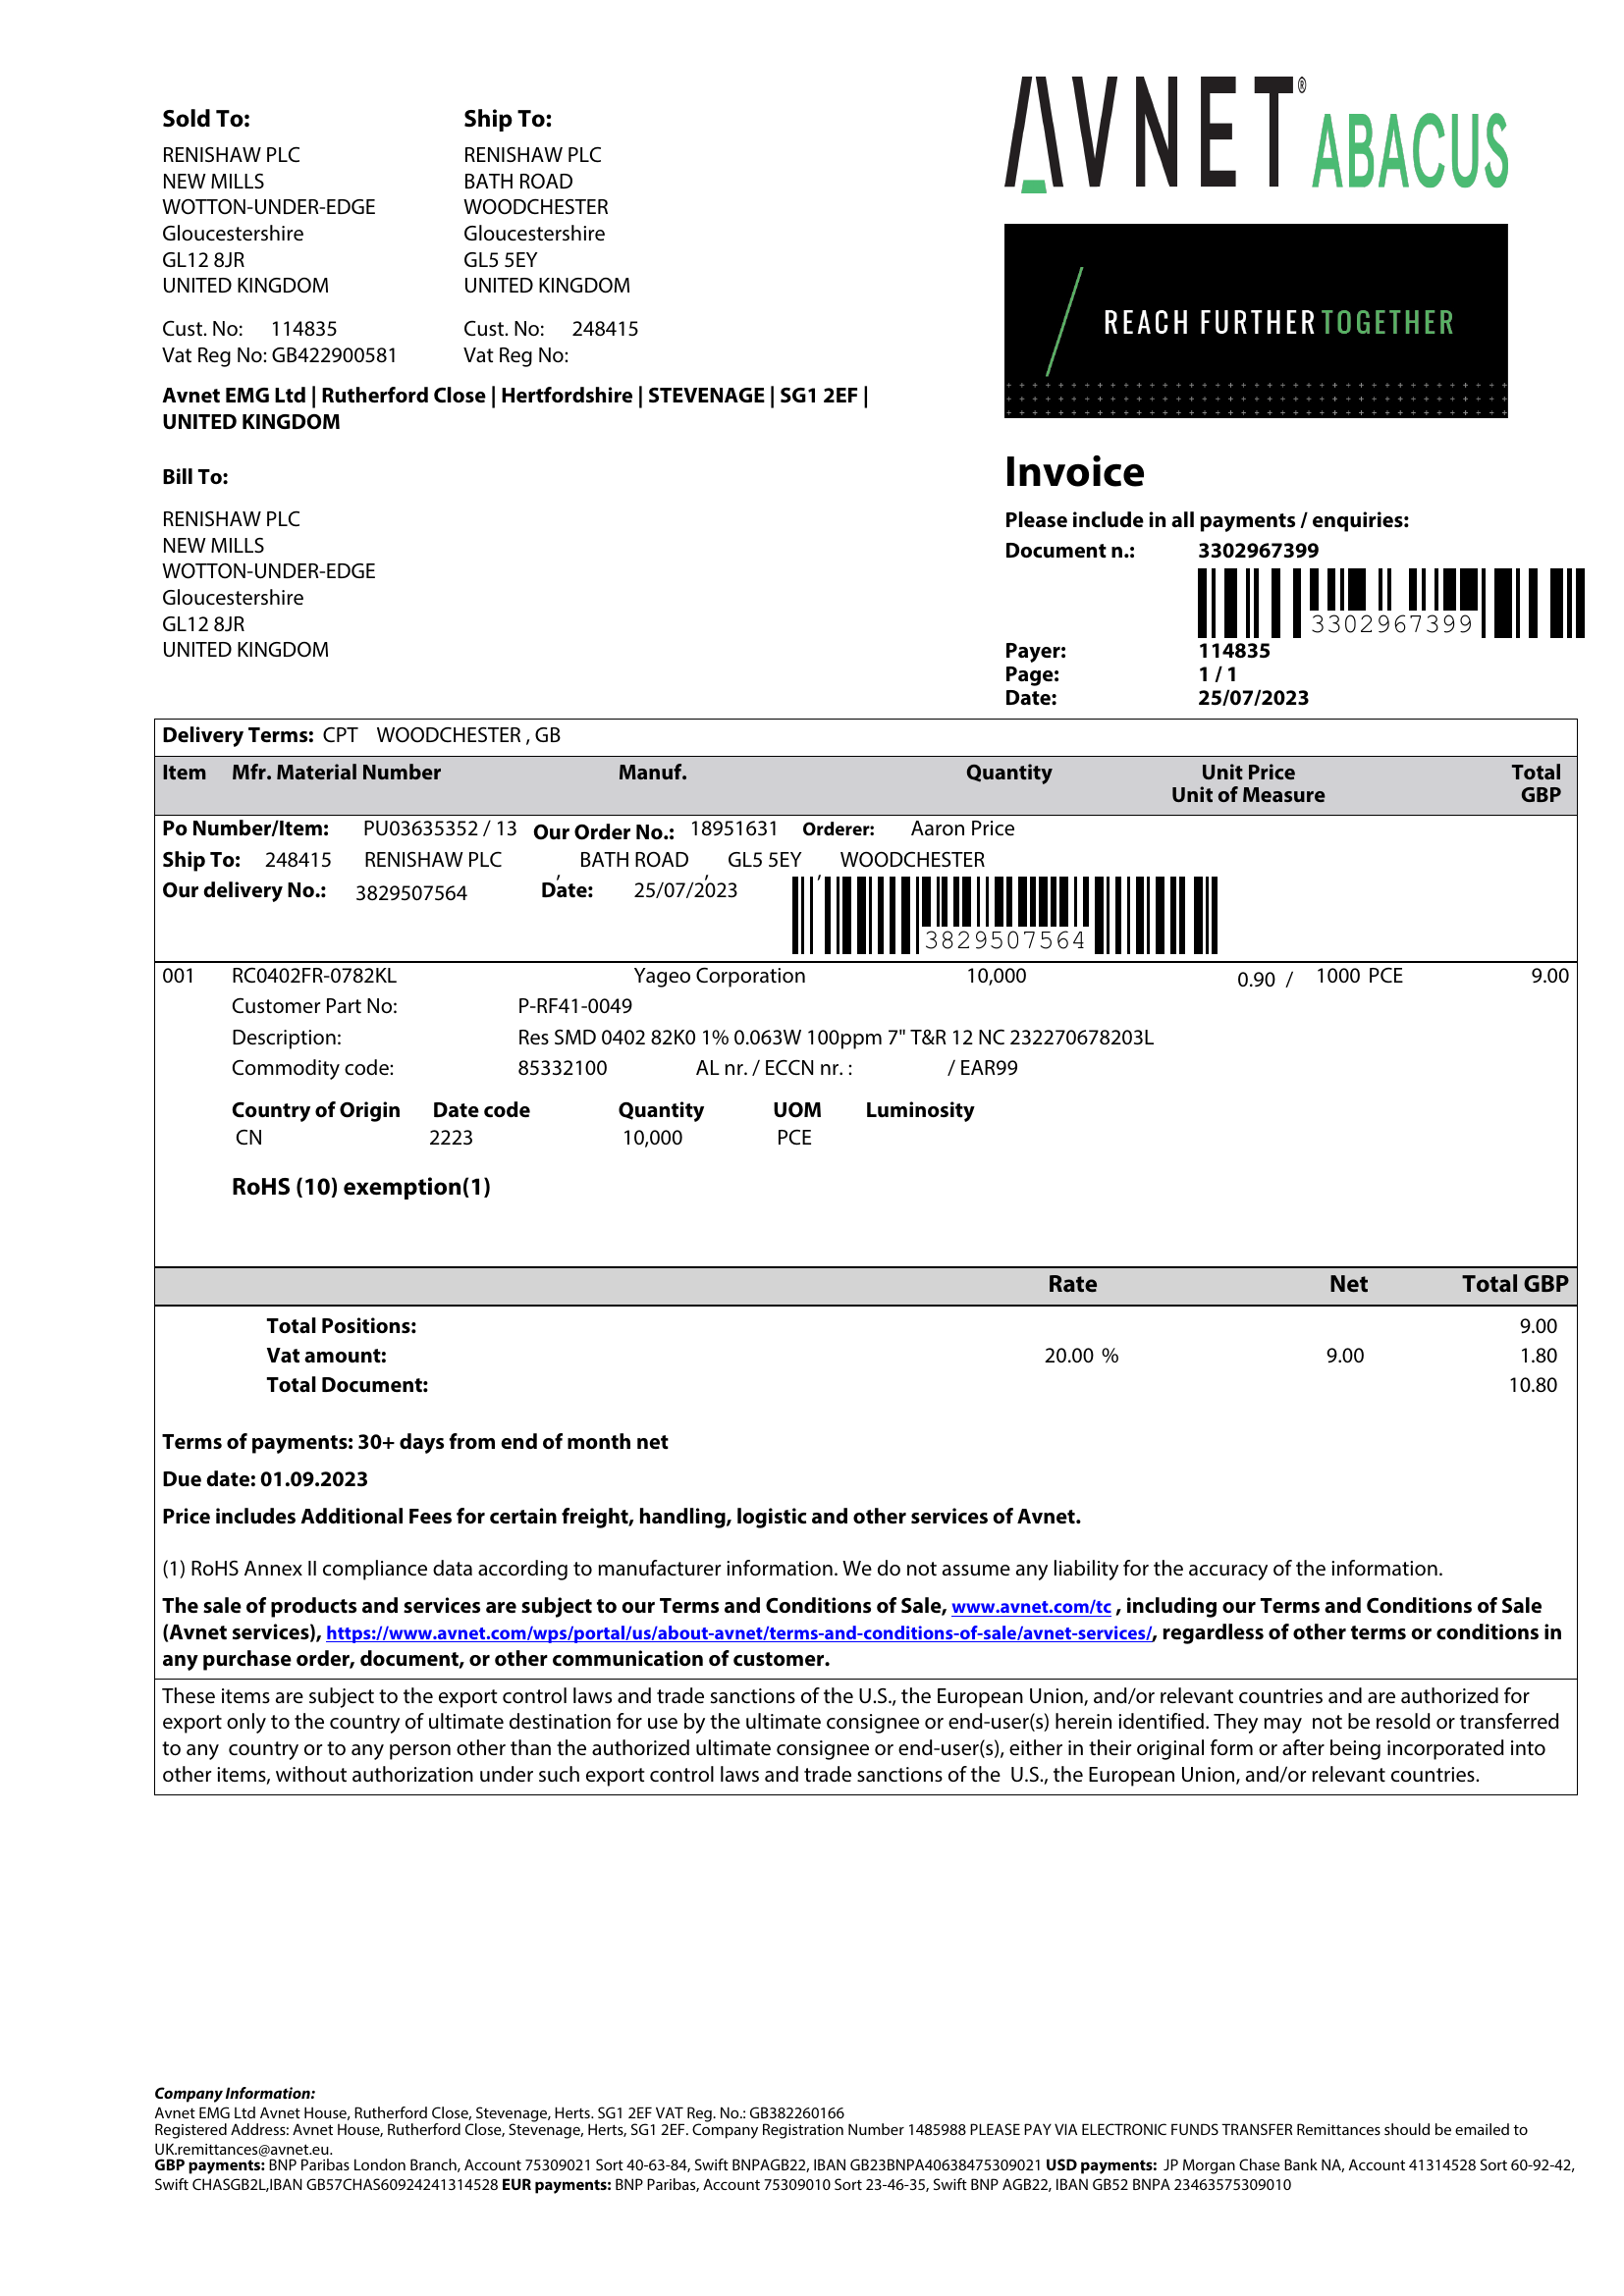

In [ ]:
image_file = "invoice/V000117 - 831955.png"

image_view(image_file)

In [19]:
result = gpt4o_imagefile(
    image_file, prompt
)
print(result.choices[0].message.content)

```json
{
    "VendorName": "Avnet EMG Ltd",
    "VendorVATRegistrationNumber": "GB382366046",
    "InvoiceOrCredit": "Invoice",
    "InvoiceNumber": "3302967399",
    "CreditReference": "",
    "InvoiceDate": "25/07/2023",
    "Currency": "GBP",
    "NetAmount": "9.00",
    "TaxAmount": "1.80",
    "Freight": "",
    "MiscCharges": "",
    "TotalAmount": "10.80",
    "Orders": [
        {
            "PONumber": "PU03635352"
        }
    ]
}
```
